In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
pd.set_option('display.precision', 10)

In [3]:
k1_info = {
    'positions': [
        (152.3, 0, 5),
        (137.4, 0, 5),
        (133.4, 0, 5),
        (129.7, 0, 5)
    ],
    'middle': [141, 0, 0],
    'folder_path': '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/k1'
}

k2_info = {
    'positions': [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ],
    'middle': [282, 200, 75],
    'folder_path': '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/k2'
}

k3_info = {
    'positions': [
        (0, 188.7, 75),
        (0, 203.6, 75),
        (0, 207.6, 75),
        (0, 211.3, 75)
    ],
    'middle': [0, 200, 75],
    'folder_path': '/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/k3'
}

In [4]:
comparison_dict = {
    'a1': ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1', 'tdoa23_k1'],
    'a2': ['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa23_k2'],
    'a3': ['tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3'],
    'b1': ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1', 'tdoa23_k1',
         'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa23_k2'],
    'b2': ['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa23_k2',
         'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3'],
    'b3': ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1', 'tdoa23_k1',
         'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3'],
    'c': ['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1', 'tdoa23_k1',
         'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa23_k2',
         'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']
}

intra_comparison_dict = {
    'b1': ['tdoa00_k12', 'tdoa11_k12', 'tdoa22_k12', 'tdoa33_k12'],
    'b2': ['tdoa00_k23', 'tdoa11_k23', 'tdoa22_k23', 'tdoa33_k23'],
    'b3': ['tdoa00_k13', 'tdoa11_k13', 'tdoa22_k13', 'tdoa33_k13'],
    'c': ['tdoa00_k12', 'tdoa11_k12', 'tdoa22_k12', 'tdoa33_k12',
         'tdoa00_k13', 'tdoa11_k13', 'tdoa22_k13', 'tdoa33_k13',
         'tdoa00_k23', 'tdoa11_k23', 'tdoa22_k23', 'tdoa33_k23']
}

# **Load and Handle Samples**

## **Get Coords**

In [5]:
def get_cords():
    # Define the field dimensions in centimeters
    field_width = 280  # in cm
    field_height = 400  # in cm

    # Define the point spacing in centimeters
    point_spacing = 20  # in cm

    # Define the table's properties
    table_z = 75  # height of the table in cm
    table_x_min = 70  # x coordinate of the left edge of the table
    table_x_max = 210  # x coordinate of the right edge of the table
    table_y_min = 330  # y coordinate of the top edge of the table
    table_y_max = 400  # y coordinate of the bottom edge of the table

    # Calculate the number of points along each axis
    num_points_x = field_width // point_spacing + 1
    num_points_y = field_height // point_spacing + 1

    # Generate the points
    points = []
    index = 0

    for y in range(int(num_points_y)):
        for x in range(int(num_points_x)):
            point_x = x * point_spacing
            point_y = y * point_spacing

            # Check if the point is within the table's footprint
            if table_x_min <= point_x <= table_x_max and table_y_min <= point_y <= table_y_max:
                point_z = table_z  # Points on the table have z-coordinate 75
            else:
                point_z = 0  # Points on the ground have z-coordinate 0

            points.append({str(index): (point_x, point_y, point_z)})
            index += 1
    return points

## **Load and Store Samples**

In [6]:
tot_coords = get_cords()
coordinates = [list(cor.values())[0] for cor in tot_coords]

In [ ]:
def create_samples_dict(coordinates):
    samples_dict = {}
    sample_count = 0
    for cor in coordinates:
        k1_path = k1_info['folder_path'] + f'/{cor}_1.wav'
        k2_path = k2_info['folder_path'] + f'/{cor}_2.wav'
        k3_path = k3_info['folder_path'] + f'/{cor}_3.wav'
        # load samples
        y_k1, sr_k1 = librosa.load(k1_path, mono=False, sr=None)
        y_k2, sr_k2 = librosa.load(k2_path, mono=False, sr=None)
        y_k3, sr_k3 = librosa.load(k3_path, mono=False, sr=None)
        samples_dict[cor] = [y_k1, y_k2, y_k3]
        sample_count += 1
    print(f'{sample_count} number of samples loaded into dictionary.')
    return samples_dict

In [ ]:
samples_dict = create_samples_dict(coordinates)

315 number of samples loaded into dictionary.


In [ ]:
# Save dictionary
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/samples_dict.pkl', 'wb') as file:
    pickle.dump(samples_dict, file)
    print('Saved Dictionary.')

Saved Dictionary.


In [ ]:
# Load samples dictionary
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/samples_dict.pkl', 'rb') as file:
    loaded_dict = pickle.load(file)
    print('Loaded Dictionary.')
    print(len(loaded_dict), len(loaded_dict[(60, 320, 0)]), loaded_dict[(220, 120, 0)][0].shape)

Loaded Dictionary.
315 3 (4, 103424)


## **Denoise Samples**

In [ ]:
def spectral_subtraction(audio, sr=16000, threshold=145000):
    # Compute STFT (Short-time Fourier transform)
    S = librosa.stft(audio)
    magnitude, phase = np.abs(S), np.angle(S)
    # Estimate noise spectrum from initial silent frames
    noise_estimate = np.mean(magnitude[:, :], axis=1, keepdims=True)
    # Perform spectral subtraction
    clean_magnitude = np.maximum(magnitude - noise_estimate, 0)
    # Reconstruct the denoised audio signal
    clean_S = clean_magnitude * np.exp(1j * phase)
    clean_audio = librosa.istft(clean_S)
    clean_audio = np.pad(clean_audio, ((threshold - len(clean_audio)) // 2, (threshold - len(clean_audio)) // 2))
    return clean_audio

In [ ]:
def denoise_kinect_samples(kinect_samples):
    for i in range(len(kinect_samples)):
        ch0, ch1, ch2, ch3 = kinect_samples[i][0], kinect_samples[i][1], kinect_samples[i][2], kinect_samples[i][3]
        ch0 = spectral_subtraction(ch0)
        ch1 = spectral_subtraction(ch1)
        ch2 = spectral_subtraction(ch2)
        ch3 = spectral_subtraction(ch3)
        kinect_samples[i] = np.array([ch0, ch1, ch2, ch3])
    return kinect_samples

In [ ]:
# handle long samples
threshold = 145000
long_cors = [(140, 260, 0), (160, 260, 0), (180, 260, 0), (200, 260, 0), (220, 260, 0), (240, 260, 0), (180, 280, 0), (180, 300, 0), (220, 300, 0)]

def handle_large_samples(dic, long_cors, threshold):
    for cor in long_cors:
        k1_data, k2_data, k3_data = dic[cor]
        print(f'{cor}: {dic[cor][0].shape}', end='')
        if k1_data.shape[1] > threshold:
            width = (k1_data.shape[1] - threshold) // 2
            k1_data = np.array([k1_data[0][width:(k1_data.shape[1] - width)], k1_data[1][width:(k1_data.shape[1] - width)], k1_data[2][width:(k1_data.shape[1] - width)], k1_data[3][width:(k1_data.shape[1] - width)]])
        if k2_data.shape[1] > threshold:
            width = (k2_data.shape[1] - threshold) // 2
            k2_data = np.array([k2_data[0][width:(k2_data.shape[1] - width)], k2_data[1][width:(k2_data.shape[1] - width)], k2_data[2][width:(k2_data.shape[1] - width)], k2_data[3][width:(k2_data.shape[1] - width)]])
        if k3_data.shape[1] > threshold:
            width = (k3_data.shape[1] - threshold) // 2
            k3_data = np.array([k3_data[0][width:(k3_data.shape[1] - width)], k3_data[1][width:(k3_data.shape[1] - width)], k3_data[2][width:(k3_data.shape[1] - width)], k3_data[3][width:(k3_data.shape[1] - width)]])
        dic[cor] = k1_data, k2_data, k3_data
        print(f' changed to {dic[cor][0].shape}.')

handle_large_samples(loaded_dict, long_cors, threshold)

(140, 260, 0): (4, 145000) changed to (4, 145000).
(160, 260, 0): (4, 145000) changed to (4, 145000).
(180, 260, 0): (4, 90112) changed to (4, 90112).
(200, 260, 0): (4, 145000) changed to (4, 145000).
(220, 260, 0): (4, 145000) changed to (4, 145000).
(240, 260, 0): (4, 145000) changed to (4, 145000).
(180, 280, 0): (4, 145000) changed to (4, 145000).
(180, 300, 0): (4, 145000) changed to (4, 145000).
(220, 300, 0): (4, 145000) changed to (4, 145000).


In [ ]:
k1_samples = [data[0] for data in loaded_dict.values()]
k2_samples = [data[1] for data in loaded_dict.values()]
k3_samples = [data[2] for data in loaded_dict.values()]

k1_denoised_data = denoise_kinect_samples(k1_samples)
k2_denoised_data = denoise_kinect_samples(k2_samples)
k3_denoised_data = denoise_kinect_samples(k3_samples)

In [ ]:
# make denoised dictionary
denoised_dict = {}
for i in range(len(coordinates)):
    l = []
    l.append(k1_denoised_data[i])
    l.append(k2_denoised_data[i])
    l.append(k3_denoised_data[i])
    denoised_dict[coordinates[i]] = l

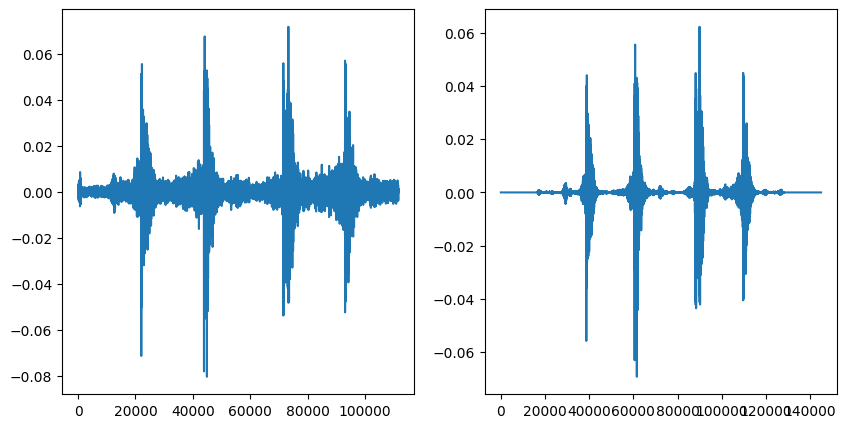

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(loaded_dict[(20, 120, 0)][0][0])
axes[1].plot(denoised_dict[(20, 120, 0)][0][0])
plt.show()

In [ ]:
# Save dictionary
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_samples_dict.pkl', 'wb') as file:
    pickle.dump(denoised_dict, file)
    print('Saved Dictionary.')

Saved Dictionary.


# **GCC-PHAT Algorithm**

In [7]:
def gcc_phat(sig, refsig, fs=1, max_tau=6.5889212827988338192419825072886e-4, interp=20):

    # Get summation of the shapes of two signals
    n = np.shape(sig)[0] + np.shape(refsig)[0]

    # applies hanning window before DRFFT (discrete real fast fourier transform)
    window = np.hanning(len(sig))

    # applies FFT on both signals and gets the cross power spectral density (CPSD)
    SIG = np.fft.rfft(sig*window, n=n)
    REFSIG = np.fft.rfft(refsig*window, n=n)
    G = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(G / np.abs(G), n=(interp * n))

    # where to shift xcorr graph to get negative tau
    shift = int(interp * n / 2)

    if max_tau:
        shift = np.minimum(int(interp * fs * max_tau), shift)

    cc = np.concatenate((cc[-shift:], cc[:shift + 1]))

    # find max cross correlation index
    argmax = np.argmax(cc) - shift

    tau = argmax / float(interp * fs)
    return tau, cc

# **Calculate TDOA values**

## **Calculate Inter Kinect TDOAS**

In [8]:
# Load samples dictionary
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_samples_dict.pkl', 'rb') as file:
    denoised_dict = pickle.load(file)
    print('Loaded Dictionary.')
    print(len(denoised_dict), len(denoised_dict[(60, 320, 0)]), denoised_dict[(220, 120, 0)][0].shape)

Exception ignored in: <function _xla_gc_callback at 0x7f4c438c63b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f4c438c63b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f4c438c63b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f4c438c63b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_

Loaded Dictionary.
315 3 (4, 145000)


In [9]:
def calc_tdoas(y, sr, multi_ch=True, idx=1):
    if multi_ch:
        num_ch = y.shape[0]
        ch0, ch1, ch2, ch3 = [y[i, :] for i in range(num_ch)]
        # Calc tdoas
        tdoas = {}
        tdoas[f'tdoa01_k{idx}'], cc = gcc_phat(ch0, ch1, sr)
        tdoas[f'tdoa02_k{idx}'], cc = gcc_phat(ch0, ch2, sr)
        tdoas[f'tdoa03_k{idx}'], cc = gcc_phat(ch0, ch3, sr)
        tdoas[f'tdoa12_k{idx}'], cc = gcc_phat(ch1, ch2, sr)
        tdoas[f'tdoa13_k{idx}'], cc = gcc_phat(ch1, ch3, sr)
        tdoas[f'tdoa23_k{idx}'], cc = gcc_phat(ch2, ch3, sr)
        return tdoas
    else:
        raise 'Not multi channel'

def merge(dict1, dict2):
    for key in dict2:
        if key in dict1:
            dict1[key].append(dict2[key])
        else:
            dict1[key] = [dict2[key]]
    return dict1

def calc_tdoas_for_samples(samples_dict, sr=16000):
    # columns
    d = {'tdoa01_k1': [], 'tdoa02_k1': [], 'tdoa03_k1': [], 'tdoa12_k1': [], 'tdoa13_k1': [], 'tdoa23_k1': [],
         'tdoa01_k2': [], 'tdoa02_k2': [], 'tdoa03_k2': [], 'tdoa12_k2': [], 'tdoa13_k2': [], 'tdoa23_k2': [],
         'tdoa01_k3': [], 'tdoa02_k3': [], 'tdoa03_k3': [], 'tdoa12_k3': [], 'tdoa13_k3': [], 'tdoa23_k3': [],
         'label': []}
    # fill out values
    cors = list(samples_dict.keys())
    sample_count = 0
    for cor in cors:
        kinects_data = samples_dict[cor]
        tdoas_k1 = calc_tdoas(kinects_data[0], sr, idx=1)
        d = merge(d, tdoas_k1)
        tdoas_k2 = calc_tdoas(kinects_data[1], sr, idx=2)
        d = merge(d, tdoas_k2)
        tdoas_k3 = calc_tdoas(kinects_data[2], sr, idx=3)
        d = merge(d, tdoas_k3)
        d['label'].append(cor)
        sample_count += 1
        print(f'sample {cor} seen.', end=' ')
    # create dataframe
    print(f'\n{sample_count} number of samples seen.')
    print(d)
    df = pd.DataFrame(data=d, dtype=np.float64)
    return df

In [10]:
tdoas_df = calc_tdoas_for_samples(denoised_dict, sr=16000)

KeyboardInterrupt: 

In [ ]:
print(tdoas_df.head)

In [ ]:
# Save dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_tdoa_df_int20.pkl', 'wb') as file:
    pickle.dump(tdoas_df, file)
    print('Saved TDOAs dataframe.')

In [ ]:
# Load dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_tdoa_df_int20.pkl', 'rb') as file:
    loaded_df = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(loaded_df), '\nShape:', loaded_df.shape, '\nOverview:', loaded_df)

## **Calculate Intra Kinect TDOAs**

In [ ]:
def handle_different_shapes(y1, y2):
    y2_shorter = False
    if y1.shape[1] > y2.shape[1]:
        larger = y1
        shorter = y2
        y2_shorter = True
    else:
        larger = y2
        shorter = y1
    dif = larger.shape[1] - shorter.shape[1]
    if dif % 2:
        shorter = np.pad(shorter, pad_width=((0, 0), (dif//2, (dif//2)+1)))
    else:
        shorter = np.pad(shorter, pad_width=((0, 0), (dif//2, dif//2)))
    if y2_shorter:
        return larger, shorter
    else:
        return shorter, larger

In [ ]:
def calc_intra_tdoas(y1, y2, idx1, idx2, sr=16000, multi_ch=True):
    if multi_ch:
        y1, y2 = handle_different_shapes(y1, y2)
        num_ch = y1.shape[0]
        ch0_f, ch1_f, ch2_f, ch3_f = [y1[i, :] for i in range(num_ch)]
        ch0_s, ch1_s, ch2_s, ch3_s = [y2[i, :] for i in range(num_ch)]
        # Calc tdoas
        tdoas = {}
        tdoas[f'tdoa00_k{idx1}{idx2}'], cc = gcc_phat(ch0_f, ch0_s, sr)
        tdoas[f'tdoa11_k{idx1}{idx2}'], cc = gcc_phat(ch1_f, ch1_s, sr)
        tdoas[f'tdoa22_k{idx1}{idx2}'], cc = gcc_phat(ch2_f, ch2_s, sr)
        tdoas[f'tdoa33_k{idx1}{idx2}'], cc = gcc_phat(ch3_f, ch3_s, sr)
        return tdoas
    else:
        raise 'Not multi channel'

def merge(dict1, dict2):
    for key in dict2:
        if key in dict1:
            dict1[key].append(dict2[key])
        else:
            dict1[key] = [dict2[key]]
    return dict1

def calc_intra_tdoas_for_samples(samples_dict, sr=16000):
    # columns
    d = {'tdoa00_k12': [], 'tdoa11_k12': [], 'tdoa22_k12': [], 'tdoa33_k12': [],
         'tdoa00_k13': [], 'tdoa11_k13': [], 'tdoa22_k13': [], 'tdoa33_k13': [],
         'tdoa00_k23': [], 'tdoa11_k23': [], 'tdoa22_k23': [], 'tdoa33_k23': [],
         'label': []}
    # fill out values
    cors = list(samples_dict.keys())
    sample_count = 0
    for cor in cors:
        kinects_data = samples_dict[cor]
        tdoas_12 = calc_intra_tdoas(kinects_data[0], kinects_data[1], 1, 2, sr)
        d = merge(d, tdoas_12)
        tdoas_13 = calc_intra_tdoas(kinects_data[0], kinects_data[2], 1, 3, sr)
        d = merge(d, tdoas_13)
        tdoas_23 = calc_intra_tdoas(kinects_data[1], kinects_data[2], 2, 3, sr)
        d = merge(d, tdoas_23)
        d['label'].append(cor)
        sample_count += 1
        print(f'sample {cor} seen.', end=' ')
    # create dataframe
    print(f'\n{sample_count} number of samples seen.')
    print(d)
    df = pd.DataFrame(data=d, dtype=np.float64)
    return df

In [ ]:
tdoas_df = calc_intra_tdoas_for_samples(loaded_dict, sr=16000)

In [ ]:
# Save dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/intra_tdoa_df_int20.pkl', 'wb') as file:
    pickle.dump(tdoas_df, file)
    print('Saved TDOAs dataframe.')

In [ ]:
# Load dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/intra_tdoa_df_int20.pkl', 'rb') as file:
    loaded_df = pickle.load(file)
    print('Loaded Intra TDOAs dataframe.')
    print('Type:', type(loaded_df), '\nShape:', loaded_df.shape, '\nOverview:', loaded_df)

In [ ]:
# Concatenate two dataframes
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/tdoa_df_int20.pkl', 'rb') as file:
    inter_df = pickle.load(file)
    print('Loaded inter TDOAs dataframe.')
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/intra_tdoa_df_int20.pkl', 'rb') as file:
    intra_df = pickle.load(file)
    print('Loaded Intra TDOAs dataframe.')

# create and scve the concatenated dataframe
concatenated = pd.concat([inter_df, intra_df.drop('label', axis=1)], axis=1)
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/concat_tdoa_df_int20.pkl', 'wb') as file:
    pickle.dump(concatenated, file)
    print('Saved Concatenated TDOAs dataframe.')

## **Actual TDOA values**

In [ ]:
def calc_act_tdoa(cor, k1_pos, k2_pos, k3_pos, num_of_kinects=3):
    x, y, z = cor
    mic_poses = [k1_pos, k2_pos, k3_pos]
    tdoa_vals = []
    for idx in range(num_of_kinects):
        distances = []
        mic_pos = mic_poses[idx]
        for i in range(0, 4):
            distances.append(math.sqrt((x - mic_pos[i][0])**2 + (y - mic_pos[i][1])**2 + (z - mic_pos[i][2])**2))
        toas = []
        for i in range(0, 4):
            toas.append(distances[i] / 34300)
        tdoas = {
        f'tdoa01_k{idx+1}': toas[0] - toas[1],
        f'tdoa02_k{idx+1}': toas[0] - toas[2],
        f'tdoa03_k{idx+1}': toas[0] - toas[3],
        f'tdoa12_k{idx+1}': toas[1] - toas[2],
        f'tdoa13_k{idx+1}': toas[1] - toas[3],
        f'tdoa23_k{idx+1}': toas[2] - toas[3]
        }
        tdoa_vals.append(tdoas)
    return tdoa_vals

def create_actual_tdoas_df(coordinates, k1_pos, k2_pos, k3_pos):
    # columns
    d = {'tdoa01_k1': [], 'tdoa02_k1': [], 'tdoa03_k1': [], 'tdoa12_k1': [], 'tdoa13_k1': [], 'tdoa23_k1': [],
         'tdoa01_k2': [], 'tdoa02_k2': [], 'tdoa03_k2': [], 'tdoa12_k2': [], 'tdoa13_k2': [], 'tdoa23_k2': [],
         'tdoa01_k3': [], 'tdoa02_k3': [], 'tdoa03_k3': [], 'tdoa12_k3': [], 'tdoa13_k3': [], 'tdoa23_k3': [],
         'label': []}
    sample_count = 0
    for cor in coordinates:
        # fill out values
        tdoas_k1, tdoas_k2, tdoas_k3 = calc_act_tdoa(cor, k1_pos, k2_pos, k3_pos)
        d = merge(d, tdoas_k1)
        d = merge(d, tdoas_k2)
        d = merge(d, tdoas_k3)
        d['label'].append(cor)
        sample_count += 1
        print(f'sample {cor} seen.', end=' ')
    # create dataframe
    print(f'\n{sample_count} number of samples seen.')
    df = pd.DataFrame(data=d, dtype=np.float64)
    return df

In [ ]:
act_tdoa_df = create_actual_tdoas_df(coordinates, k1_info['positions'], k2_info['positions'], k3_info['positions'])

In [ ]:
print(act_tdoa_df.shape)
print(act_tdoa_df)

In [ ]:
# Save dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/actual_tdoa.pkl', 'wb') as file:
    pickle.dump(act_tdoa_df, file)
    print('Saved TDOAs dataframe.')

# **Determine Test Points**

In [11]:
def get_test_coors(test_coors_x, test_coors_y):
    test_coors_z = []
    for x, y in zip(test_coors_x, test_coors_y):
        if y >= 330 and x >= 70 and x <= 210:
            test_coors_z.append(75)
        else:
            test_coors_z.append(0)
    test_coors = [(x, y, z) for x, y, z in zip(test_coors_x, test_coors_y, test_coors_z)]
    return test_coors

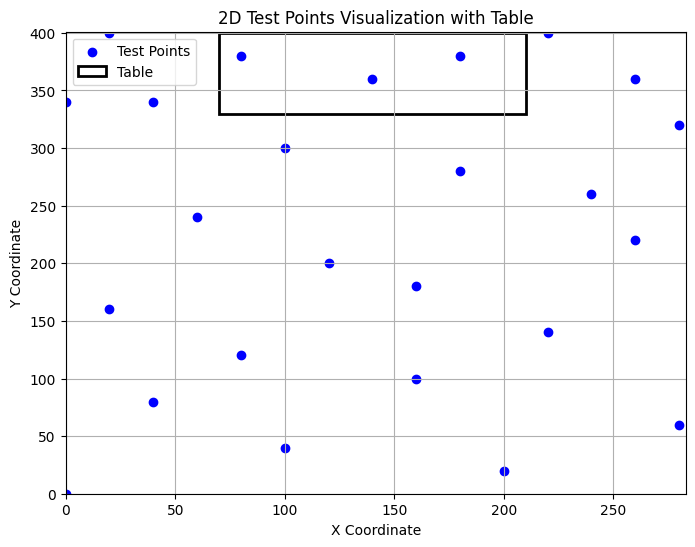

In [12]:
# determine test
test_coors_x = [0, 200, 100, 280, 40, 160, 80, 220, 20, 160, 120, 260, 60, 240, 180, 100, 280, 40, 260, 80, 220, 0, 140, 180, 20]
test_coors_y = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 340, 360, 380, 400]
# test_coors_x = [0, 200, 100, 280, 160, 80, 20, 160, 120, 260, 60, 240, 100, 280, 40, 80, 220, 0, 180, 20]
# test_coors_y = [0, 20, 40, 60, 100, 120, 160, 180, 200, 220, 240, 260, 300, 320, 340, 380, 400, 340, 380, 400]
test_coors = get_test_coors(test_coors_x, test_coors_y)
# determine train
tot_coords = get_cords()
coordinates = [list(cor.values())[0] for cor in tot_coords]
train_coors = [cor for cor in coordinates if cor not in test_coors]

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_test_points_with_table(test_coors):
    # Extract x, y coordinates from test_coors
    x_vals = [coor[0] for coor in test_coors]
    y_vals = [coor[1] for coor in test_coors]

    # Create a 2D scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_vals, y_vals, c='blue', marker='o', label='Test Points')

    # Add a rectangle to represent the table
    table_x, table_y, table_width, table_height = 70, 330, 140, 70  # (x, y, width, height)
    table = patches.Rectangle((table_x, table_y), table_width, table_height,
                              linewidth=2, edgecolor='black', facecolor='none', linestyle='-', label='Table')
    plt.gca().add_patch(table)

    # Labeling the plot
    plt.title('2D Test Points Visualization with Table')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)

    # Set limits to better visualize the table and test points
    plt.xlim(0, 283)
    plt.ylim(0, 401)

    # Show plot
    plt.show()

# Example usage:
visualize_test_points_with_table(test_coors)



In [13]:
print('Number of Train coords:', len(train_coors))
print('Number of Test coords:', len(test_coors))

Number of Train coords: 290
Number of Test coords: 25


# **Surface Prediction**

In [14]:
# Load tdoa dataframe
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/tdoa_df_int20.pkl', 'rb') as file:
    df = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(df), '\nShape:', df.shape, '\nOverview:', df)

Loaded TDOAs dataframe.
Type: <class 'pandas.core.frame.DataFrame'> 
Shape: (315, 19) 
Overview:        tdoa01_k1    tdoa02_k1    tdoa03_k1    tdoa12_k1    tdoa13_k1  \
0    0.000075000  0.000537500  0.000678125  0.000050000  0.000200000   
1    0.000471875  0.000500000  0.000646875  0.000043750  0.000181250   
2    0.000487500  0.000456250  0.000653125  0.000062500  0.000146875   
3    0.000431250  0.000584375  0.000678125  0.000062500  0.000184375   
4    0.000425000  0.000575000  0.000675000  0.000065625  0.000215625   
..           ...          ...          ...          ...          ...   
310 -0.000018750 -0.000018750 -0.000028125 -0.000006250 -0.000012500   
311 -0.000043750 -0.000025000 -0.000031250 -0.000012500 -0.000025000   
312 -0.000012500 -0.000018750 -0.000012500 -0.000006250 -0.000012500   
313 -0.000062500 -0.000050000 -0.000071875 -0.000015625 -0.000021875   
314 -0.000056250 -0.000059375 -0.000078125 -0.000012500 -0.000028125   

       tdoa23_k1    tdoa01_k2    tdoa0

In [15]:
# add surface label
def add_surface_label(df):
    surfaces = []
    if 'surface' in list(df.columns):
        return df
    for label in df['label']:
        if label[2] == 75:
            surfaces.append('Table')
        else:
            surfaces.append('Ground')
    df.insert(len(df.columns), 'surface', surfaces, True)
    return df

In [16]:
comparison_idx = 'b2'

In [17]:
# add surface label
# df = mfcc_df
df = add_surface_label(df)

# split train and test coords
train_df = df[df['label'].isin(train_coors)]
test_df = df[df['label'].isin(test_coors)]

# train_test_columns = comparison_dict[comparison_idx] + intra_comparison_dict[comparison_idx]
train_test_columns = comparison_dict[comparison_idx]
train_test_columns = [train_test_columns[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

# Prepare the data
X_train = train_df.drop(['surface', 'label'], axis=1)
X_train = X_train[train_test_columns]
print(X_train.columns)
X_test = test_df.drop(['surface', 'label'], axis=1)
X_test = X_test[train_test_columns]
y_train = train_df['surface']
y_test = test_df['surface']

# Encode labels
label_encoder_surface = LabelEncoder()
y_train = label_encoder_surface.fit_transform(y_train)
y_test = label_encoder_surface.transform(y_test)

# Standardize the features
scaler_surface = StandardScaler()
X_train = scaler_surface.fit_transform(X_train)
X_test = scaler_surface.transform(X_test)

Index(['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2',
       'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3',
       'tdoa13_k3', 'tdoa23_k3'],
      dtype='object')


In [18]:
print(X_train.shape)
print(X_test.shape)

(290, 12)
(25, 12)


Random Forest Test Accuracy: 92.00%
              precision    recall  f1-score   support

      Ground       0.95      0.95      0.95        22
       Table       0.67      0.67      0.67         3

    accuracy                           0.92        25
   macro avg       0.81      0.81      0.81        25
weighted avg       0.92      0.92      0.92        25

[21, 24]


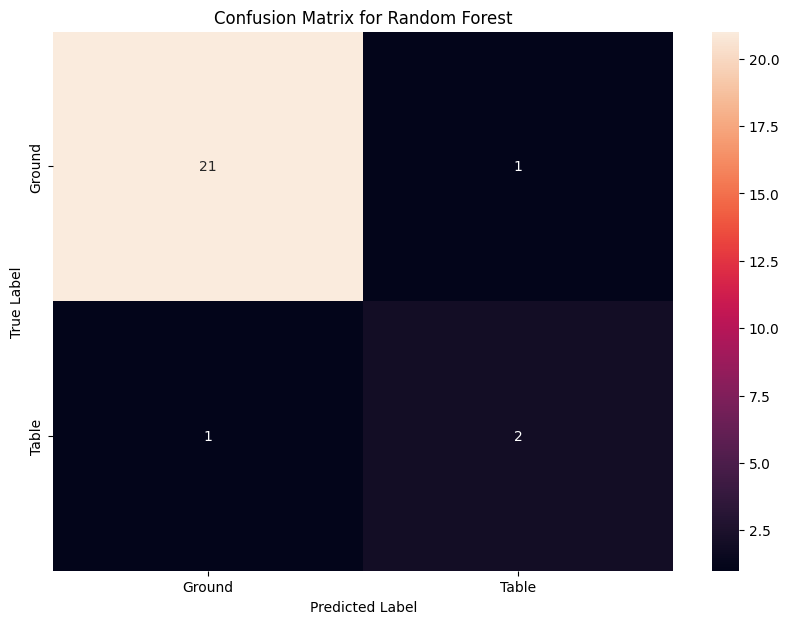

Gradient Boosting Test Accuracy: 96.00%
              precision    recall  f1-score   support

      Ground       1.00      0.95      0.98        22
       Table       0.75      1.00      0.86         3

    accuracy                           0.96        25
   macro avg       0.88      0.98      0.92        25
weighted avg       0.97      0.96      0.96        25

[24]


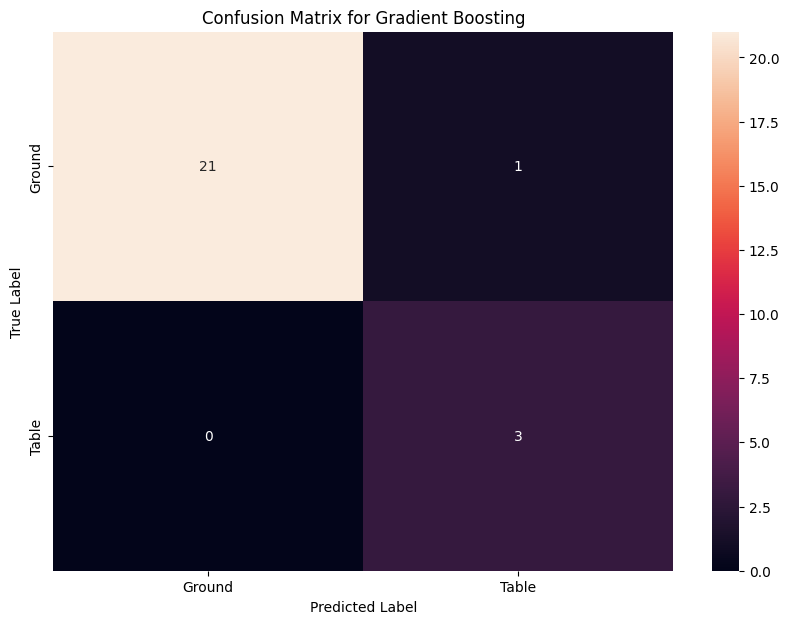

SVM Test Accuracy: 88.00%
              precision    recall  f1-score   support

      Ground       0.88      1.00      0.94        22
       Table       0.00      0.00      0.00         3

    accuracy                           0.88        25
   macro avg       0.44      0.50      0.47        25
weighted avg       0.77      0.88      0.82        25

[19, 21, 22]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


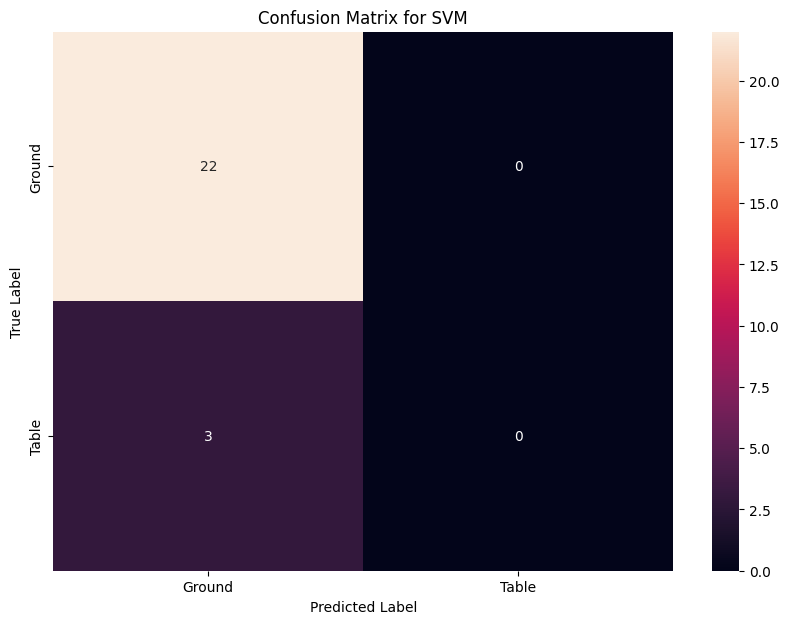

XGBoost Test Accuracy: 100.00%
              precision    recall  f1-score   support

      Ground       1.00      1.00      1.00        22
       Table       1.00      1.00      1.00         3

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

[]


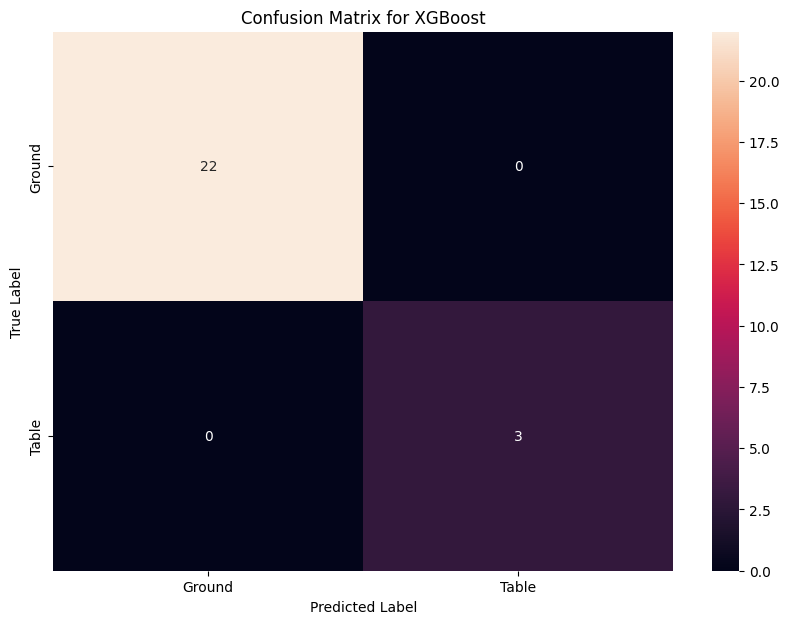

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Model training and evaluation
surface_models = {
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=2, learning_rate=1, objective='binary:logistic')
}

for model_name, model in surface_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy*100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=label_encoder_surface.classes_))
    print([i for i in range(len(y_pred)) if y_pred[i] != y_test[i]])

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder_surface.classes_, yticklabels=label_encoder_surface.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [20]:
# get surface prediction model
surface_prediction_model = surface_models['XGBoost']
print(surface_prediction_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


# **Examine Classical Approach**

## **Create Environment**

In [21]:
# Environment traits
mins = (0, 0, 0)
maxs = (283, 401, 76)
grid_resolution = 1
table_start_y = 330
table_end_y = 401
table_start_x = 70
table_end_x = 211

In [22]:
NOT_VALID = -1
VALID = 0

def create_env_array(table_start_y, table_end_y, table_start_x, table_end_x, min_margins, max_margins):
    # Extract margins
    x_min, y_min, z_min = min_margins
    x_max, y_max, z_max = max_margins
    table_margin_y = list(np.arange(table_start_y, table_end_y, grid_resolution))
    table_margin_x = list(np.arange(table_start_x, table_end_x, grid_resolution))

    # Initialize array
    arr = np.zeros((int((z_max - z_min) / grid_resolution),
                       int((y_max - y_min) / grid_resolution),
                       int((x_max - x_min) / grid_resolution))) - 1

    for z in np.arange(z_min, z_max, grid_resolution):
        for y in np.arange(y_min, y_max, grid_resolution):
            for x in np.arange(x_min, x_max, grid_resolution):
                if y in table_margin_y and x in table_margin_x:
                    if z == z_max - 1:
                        arr[int((z - z_min) / grid_resolution),
                           int((y - y_min) / grid_resolution),
                           int((x - x_min) / grid_resolution)] = VALID
                else:
                    if z == z_min:
                        arr[int((z - z_min) / grid_resolution),
                           int((y - y_min) / grid_resolution),
                           int((x - x_min) / grid_resolution)] = VALID
    return arr

env_array = create_env_array(table_start_y, table_end_y, table_start_x, table_end_x, mins, maxs)

In [23]:
print(env_array[:, 0, 0])

[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]


## **Examination Functions**

In [24]:
def calculate_mean_error(act_poses, pred_poses):
    if len(act_poses) != len(pred_poses):
        raise 'Not Equal Lengths'
    # initialize dictionary
    errors_pred = {
        'er_x': [],
        'er_y': [],
        'er_z': [],
        'total_errors': []
    }
    if len(pred_poses[0]) != 3:
        pred_poses = [list(pos) + [-1] for pos in pred_poses]
        act_poses = [list(pos) + [-1] for pos in act_poses]
    for i in range(len(act_poses)):
        pred_pos = pred_poses[i]
        actual_pos = act_poses[i]
        # Calculate error for preds
        x_final, y_final, z_final = pred_pos
        errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2 + (actual_pos[2] - z_final)**2))
        errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
        errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
        errors_pred['er_z'].append(abs((actual_pos[2] - z_final)))
    # Calculate means for preds
    means_pred = {}
    for er_name, errors in errors_pred.items():
        mean = np.mean(errors)
        means_pred['mean_of_' + er_name + ' for prediction'] = mean
    return means_pred

In [25]:
def determine_z_with_surface(surface):
    if surface == 1:
        return 75
    else:
        return 0

In [26]:
def get_expected_tdoas(distances, idx, speed=34300):
    expected_tdoas = {
        f'tdoa01_k{idx+1}': (distances[0] - distances[1]) / speed,
        f'tdoa02_k{idx+1}': (distances[0] - distances[2]) / speed,
        f'tdoa03_k{idx+1}': (distances[0] - distances[3]) / speed,
        f'tdoa12_k{idx+1}': (distances[1] - distances[2]) / speed,
        f'tdoa13_k{idx+1}': (distances[1] - distances[3]) / speed,
        f'tdoa23_k{idx+1}': (distances[2] - distances[3]) / speed
    }
    return expected_tdoas

In [27]:
def get_expected_intra_tdoas(distances1, distances2, idx1, idx2, speed=34300):
    expected_tdoas = {
        f'tdoa00_k{idx1+1}{idx2+1}': (distances1[0] - distances2[0]) / speed,
        f'tdoa11_k{idx1+1}{idx2+1}': (distances1[1] - distances2[1]) / speed,
        f'tdoa22_k{idx1+1}{idx2+1}': (distances1[2] - distances2[2]) / speed,
        f'tdoa33_k{idx1+1}{idx2+1}': (distances1[3] - distances2[3]) / speed,
    }
    return expected_tdoas

In [28]:
ranges_dict = {
    0: [(0, 75), (0, 75), 0],
    1: [(75, 155), (0, 75), 0],
    2: [(155, 235), (0, 75), 0],
    3: [(235, 282), (0, 75), 0],
    4: [(0, 75), (75, 155), 0],
    5: [(75, 155), (75, 155), 0],
    6: [(155, 235), (75, 155), 0],
    7: [(235, 282), (75, 155), 0],
    8: [(0, 75), (155, 235), 0],
    9: [(75, 155), (155, 235), 0],
    10: [(155, 235), (155, 235), 0],
    11: [(235, 282), (155, 235), 0],
    12: [(0,70), (235, 330), 0],
    13: [(70,  145), (235, 330), 0],
    14: [(145, 210), (235, 330), 0],
    15: [(210, 282), (235, 330), 0],
    16: [(0, 70), (330, 400), 0],
    17: [(70, 145), (330, 400), 75],
    18: [(145, 210), (330, 400), 75],
    19: [(210, 282), (330, 400), 0]
}

In [29]:
VALID = 0

def predict_pos_for_cor(measured_tdoas, mic_pos1, mic_pos2, mic_pos3, cols, regions_preds, z_val=-1, regions_provided=True, z_provided=True, x_minimum=0, x_maximum=283, y_minimum=0, y_maximum=401,
                        z_minimum=0, z_maximum=76, sigma=0.00001, sound_speed=34300.0, grid_resolution=1):
    # prepare heatmap
    heatmap_3d = env_array.copy()
    # determine z value
    z_values = [z_minimum, z_maximum - 1]
    if z_provided:
        z_values = [z_val]

    if regions_provided:
        (x_start, x_end), (y_start, y_end), z_val = regions_preds
        z_values = [z_val]
        x_vals = np.arange(x_start, x_end, grid_resolution)
        y_vals = np.arange(y_start, y_end, grid_resolution)
    else:
        x_vals = np.arange(x_minimum, x_maximum, grid_resolution)
        y_vals = np.arange(y_minimum, y_maximum, grid_resolution)
    z_vals = np.arange(z_minimum, z_maximum, grid_resolution)

    print(z_values)

    # Evaluating the 3D grid cells
    for z in z_vals:
        if z in z_values:
            for y in y_vals:
                for x in x_vals:
                    # Initialize a variable to accumulate likelihood for the current grid point
                    likelihood = 0
                    # Calculate distances from the grid point to each microphone
                    distances_k1 = np.linalg.norm(mic_pos1 - np.array([x, y, z]), axis=1)
                    distances_k2 = np.linalg.norm(mic_pos2 - np.array([x, y, z]), axis=1)
                    distances_k3 = np.linalg.norm(mic_pos3 - np.array([x, y, z]), axis=1)
                    # Calculate expected TDOA based on these distances
                    expected_tdoas = {}
                    expected_tdoas.update(get_expected_tdoas(distances_k1, 0))
                    expected_tdoas.update(get_expected_tdoas(distances_k2, 1))
                    expected_tdoas.update(get_expected_tdoas(distances_k3, 2))
                    expected_tdoas.update(get_expected_intra_tdoas(distances_k1, distances_k2, 0, 1))
                    expected_tdoas.update(get_expected_intra_tdoas(distances_k1, distances_k3, 0, 2))
                    expected_tdoas.update(get_expected_intra_tdoas(distances_k2, distances_k3, 1, 2))
                    # Compare the expected TDOAs with the measured TDOAs and update the likelihood
                    # print(cols)
                    # print(expected_tdoas.keys())
                    for key in cols:
                        likelihood += np.exp(-((measured_tdoas[key] - expected_tdoas[key])**2) / (2 * sigma**2))
                    # Store the likelihood in the heatmap array if valid
                    temp = heatmap_3d[int((z - z_minimum) / grid_resolution),
                               int((y - y_minimum) / grid_resolution),
                               int((x - x_minimum) / grid_resolution)]
                    if temp == VALID:
                        heatmap_3d[int((z - z_minimum) / grid_resolution),
                                   int((y - y_minimum) / grid_resolution),
                                   int((x - x_minimum) / grid_resolution)] = likelihood
    # Normalizing the heatmap values
    heatmap_3d = heatmap_3d / np.max(heatmap_3d)
    # Find the coordinates of the maximum likelihood
    z_max_idx, y_max_idx, x_max_idx = np.unravel_index(np.argmax(heatmap_3d[z_val]), heatmap_3d.shape)
    return (x_max_idx, y_max_idx, z_val)

In [32]:
import time

def predict_samples_classical(test_df, k1_pos, k2_pos, k3_pos, k1_middle, k2_middle, k3_middle, ranges_dict, regions_pred, surface_model, intra_comp_dict, comp_dict, comp_idx, cols=None):
    actual_positions = []
    predicted_positions = []
    k2_predictions = []
    k3_predictions = []
    columns = comp_dict[comp_idx] # + intra_comp_dict[comp_idx]
    ssl_columns = [columns[i] for i in [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]]
    # ssl_columns =columns
    # ssl_columns = cols
    print(ssl_columns)
    print(cols)
    # get predictions
    smpl_count = 0
    times = []
    for idx, row in test_df.iterrows():
        cor = row['label']
        actual_positions.append(cor)
        # get measured tdoas
        measured_tdoas = row.drop(['surface', 'label'])
        measured_tdoas_surface = measured_tdoas[cols]
        measured_tdoas_ssl = measured_tdoas[ssl_columns]
        # get prediction
        scaled_X = scaler_surface.transform(measured_tdoas_surface.to_frame().transpose())
        surface_predicted = surface_model.predict(scaled_X)[0]
        z = determine_z_with_surface(surface_predicted)
        # predicted_pos = predict_with_interception(measured_tdoas, k2_pos, k3_pos, k2_middle, k3_middle, z)
        start = time.perf_counter()
        predicted_pos = predict_pos_for_cor(measured_tdoas_ssl.to_dict(), k1_pos, k2_pos, k3_pos, ssl_columns, ranges_dict[regions_pred[cor]], z, regions_provided=False, z_provided=True)
        end = time.perf_counter()
        times.append(abs(end-start))
        # pred_pos, predicted_pos_k2, predicted_pos_k3 = predict_pos_for_cor_k23(measured_tdoas.to_dict(), k1_pos, k2_pos, k3_pos, comp_dict, comp_idx, z)
        smpl_count += 1
        print(f'{smpl_count}- Sample {cor} Predicted.')
        predicted_positions.append(predicted_pos)
    return predicted_positions, actual_positions, ssl_columns, np.mean(times)

## **Examination**

In [31]:
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/random_forest_regions_pred.pkl', 'rb') as file:
    regions_pred = pickle.load(file)
print(regions_pred)

# regions_pred = {
# (0, 0, 0): 0,
# (200, 20, 0): 2,
# (100, 40, 0): 1,
# (280, 60, 0): 3,
# (40, 80, 0): 0,
# (160, 100, 0): 6,
# (80, 120, 0): 4,
# (220, 140, 0): 6,
# (20, 160, 0): 8,
# (160, 180, 0): 10,
# (120, 200, 0): 9,
# (260, 220, 0): 15,
# (60, 240, 0): 13,
# (240, 260, 0): 15,
# (180, 280, 0): 14,
# (100, 300, 0): 13,
# (280, 320, 0): 15,
# (40, 340, 0): 16,
# (260, 360, 0): 15,
# (80, 380, 75): 17,
# (220, 400, 0): 18,
# (0, 340, 0): 12,
# (140, 360, 75): 18,
# (180, 380, 75): 18,
# (20, 400, 0): 17
# }

actual_regs = {
(0, 0, 0):  0,
(200, 20, 0):  2,
(100, 40, 0):  1,
(280, 60, 0):  3,
(40, 80, 0):  4,
(160, 100, 0):  6,
(80, 120, 0):  5,
(220, 140, 0):  6,
(20, 160, 0):  8,
(160, 180, 0) : 10,
(120, 200, 0):  9,
(260, 220, 0): 11,
(60, 240, 0) : 12,
(240, 260, 0): 15,
(180, 280, 0): 14,
(100, 300, 0): 13,
(280, 320, 0): 15,
(40, 340, 0): 16,
(260, 360, 0): 19,
(80, 380, 75): 17,
(220, 400, 0): 19,
(0, 340, 0): 16,
(140, 360, 75): 17,
(180, 380, 75): 18,
(20, 400, 0): 16
}

{(0, 0, 0): 0, (200, 20, 0): 2, (100, 40, 0): 1, (280, 60, 0): 3, (40, 80, 0): 0, (160, 100, 0): 6, (80, 120, 0): 5, (220, 140, 0): 6, (20, 160, 0): 8, (160, 180, 0): 10, (120, 200, 0): 9, (260, 220, 0): 11, (60, 240, 0): 12, (240, 260, 0): 15, (180, 280, 0): 14, (100, 300, 0): 13, (280, 320, 0): 19, (40, 340, 0): 16, (260, 360, 0): 19, (80, 380, 75): 17, (220, 400, 0): 19, (0, 340, 0): 16, (140, 360, 75): 17, (180, 380, 75): 18, (20, 400, 0): 16}


In [33]:
predictied_positions, act_positions, ssl_cols, mean_time = predict_samples_classical(test_df, k1_info['positions'], k2_info['positions'], k3_info['positions'], k1_info['middle'], k2_info['middle'], k3_info['middle'], ranges_dict, regions_pred, surface_prediction_model, intra_comparison_dict, comparison_dict, comparison_idx, train_test_columns)

['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']
['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2', 'tdoa13_k2', 'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']
[0]
1- Sample (0, 0, 0) Predicted.
[0]
2- Sample (200, 20, 0) Predicted.
[0]
3- Sample (100, 40, 0) Predicted.
[0]
4- Sample (280, 60, 0) Predicted.
[0]
5- Sample (40, 80, 0) Predicted.
[0]
6- Sample (160, 100, 0) Predicted.
[0]
7- Sample (80, 120, 0) Predicted.
[0]
8- Sample (220, 140, 0) Predicted.
[0]
9- Sample (20, 160, 0) Predicted.
[0]
10- Sample (160, 180, 0) Predicted.
[0]
11- Sample (120, 200, 0) Predicted.
[0]
12- Sample (260, 220, 0) Predicted.
[0]
13- Sample (60, 240, 0) Predicted.
[0]
14- Sample (240, 260, 0) Predicted.
[0]
15- Sample (180, 280, 0) Predicted.
[0]
16- Sample (100, 300, 0) Predicted.
[0]
17- Sample (280, 320, 0) Predicted.
[0]
18- Sample (0, 340, 0) Predicted.
[0

In [44]:
mean_errors_dict = calculate_mean_error(act_positions, classical_preds)
print(mean_errors_dict)
print('Mean Time:', mean_time)

{'mean_of_er_x for prediction': 21.48, 'mean_of_er_y for prediction': 14.32, 'mean_of_er_z for prediction': 0.0, 'mean_of_total_errors for prediction': 28.437512645041853}
Mean Time: 13.466432326319994


In [42]:
classical_preds = [(35, 0, 0),(201, 30, 0), (98, 51, 0), (282, 71, 0), (37, 87, 0), (175, 89, 0),
(91, 115, 0),
(228, 137, 0),
(44, 154, 0),
(208, 182, 0),
(110, 205, 0),
(228, 225, 0),
(99, 267, 0),
(135, 303, 0),
(162, 279, 0),
(111, 316, 0),
(233, 384, 0),
(0, 343, 0),
(41, 342, 0),
(195, 371, 75),
(218, 321, 0),
(75, 354, 75),
(180, 362, 75),
(5, 381, 0),
(228, 387, 0),
]

# **Results Visualization**

## **Functions**

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.ticker as ticker

# Times New Roman Font Download
k1_mic_pos = k1_info['positions']
k2_mic_pos = k2_info['positions']
k3_mic_pos = k3_info['positions']


# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start = 330
table_end = 400

# Microphone positions in 3D
mics_k1 = k1_mic_pos
mics_k2 = k2_mic_pos
mics_k3 = k3_mic_pos

microphone_xs_k1 = [sublist[0] for sublist in mics_k1]
microphone_ys_k1 = [sublist[1] for sublist in mics_k1]
microphone_zs_k1 = [sublist[2] for sublist in mics_k1]
microphone_xs_k2 = [sublist[0] for sublist in mics_k2]
microphone_ys_k2 = [sublist[1] for sublist in mics_k2]
microphone_zs_k2 = [sublist[2] for sublist in mics_k2]
microphone_xs_k3 = [sublist[0] for sublist in mics_k3]
microphone_ys_k3 = [sublist[1] for sublist in mics_k3]
microphone_zs_k3 = [sublist[2] for sublist in mics_k3]

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs
table_y_min = 330
table_y_max = 400
table_x_min = 70
table_x_max = 210
table_z = 75

# Set Times New Roman as font family

def plot_points(positions, predicted, num_of_mics, has_z=True, plot_refined=False, k1=True, k2=True, k3=True, ranges_dict=None):
    actual_positions = positions
    predicted_positions = predicted

    # kinect existence
    k_exs = [k1, k2, k3]

    # mic positions
    mic_xs = (microphone_xs_k1, microphone_xs_k2, microphone_xs_k3)
    mic_ys = (microphone_ys_k1, microphone_ys_k2, microphone_ys_k3)
    mic_zs = (microphone_zs_k1, microphone_zs_k2, microphone_zs_k3)

    # Create a 3D plot with high-quality settings
    fig = plt.figure(figsize=(30, 25))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    if not has_z:
        predicted_x, predicted_y = zip(*predicted_positions)
        predicted_z = actual_z
    else:
        predicted_x, predicted_y, predicted_z = zip(*predicted_positions)

    # Plot the actual and predicted points with professional markers
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual Ball Drop Location', s=40, alpha=0.8)
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Estimated Location', s=40, alpha=0.8)

    # Connect actual points to predicted points with dashed lines
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]],
                c='gray', linestyle='--', linewidth=1)

    # Plot microphone points with customized styling
    colors = ['purple', 'orange', 'green']
    for i in range(num_of_mics):
        if k_exs[i]:
            ax.scatter(mic_xs[i], mic_ys[i], mic_zs[i], marker='s', c=colors[i], s=60, label=f'Microphones (K{i+1})', alpha=0.9)
            for j in range(len(mic_xs[i])):
                ax.plot([mic_xs[i][j], mic_xs[i][j]], [mic_ys[i][j], mic_ys[i][j]], [mic_zs[i][j], 0],
                        c=colors[i], linestyle='-', linewidth=1.2)

    # Set grid dimensions and add gridlines
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(10))

    ax.grid(True)

    # Highlight the table range with 3D polygons
    table_vertices = [
        [(table_x_min, table_y_min, 0), (table_x_max, table_y_min, 0), (table_x_max, table_y_min, table_z), (table_x_min, table_y_min, table_z)],
        [(table_x_min, table_y_min, table_z), (table_x_max, table_y_min, table_z), (table_x_max, table_y_max, table_z), (table_x_min, table_y_max, table_z)]
    ]
    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # # Plot regions defined in ranges_dict
    # if ranges_dict:
    #     for region, coords in ranges_dict.items():
    #         x_range, y_range, z_value = coords
    #         # Define region vertices for the square
    #         region_vertices = [
    #             (x_range[0], y_range[0], z_value),
    #             (x_range[1], y_range[0], z_value),
    #             (x_range[1], y_range[1], z_value),
    #             (x_range[0], y_range[1], z_value)
    #         ]
    #         # Plot the region as a green dotted square
    #         ax.plot([region_vertices[0][0], region_vertices[1][0]], [region_vertices[0][1], region_vertices[1][1]],
    #                 [region_vertices[0][2], region_vertices[1][2]], 'g--', linewidth=1.5)
    #         ax.plot([region_vertices[1][0], region_vertices[2][0]], [region_vertices[1][1], region_vertices[2][1]],
    #                 [region_vertices[1][2], region_vertices[2][2]], 'g--', linewidth=1.5)
    #         ax.plot([region_vertices[2][0], region_vertices[3][0]], [region_vertices[2][1], region_vertices[3][1]],
    #                 [region_vertices[2][2], region_vertices[3][2]], 'g--', linewidth=1.5)
    #         ax.plot([region_vertices[3][0], region_vertices[0][0]], [region_vertices[3][1], region_vertices[0][1]],
    #                 [region_vertices[3][2], region_vertices[0][2]], 'g--', linewidth=1.5)

    # Label the axes with larger font sizes
    ax.set_xlabel('X', fontsize=14, labelpad=10)
    ax.set_ylabel('Y', fontsize=14, labelpad=10)
    ax.set_zlabel('Z', fontsize=14, labelpad=10)

    # Customize ticks and labels for better visibility
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add a legend with larger font size
    # ax.legend(fontsize=12)

    # Save the plot as a high-resolution PDF
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Taarlab/surface_clasification.pdf', format='pdf', dpi=600)

    # Show the plot
    plt.show()


## **Visualization**

Number of Training Samples: 290
Number of Test Samples: 25
Method: Results for Classical approach using 3 Kinects
GCC-PHAT interpolation: 20
Surface Classification Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Classification Accuracy: 100.0%
K1 samples used: True 
K2 samples used: False 

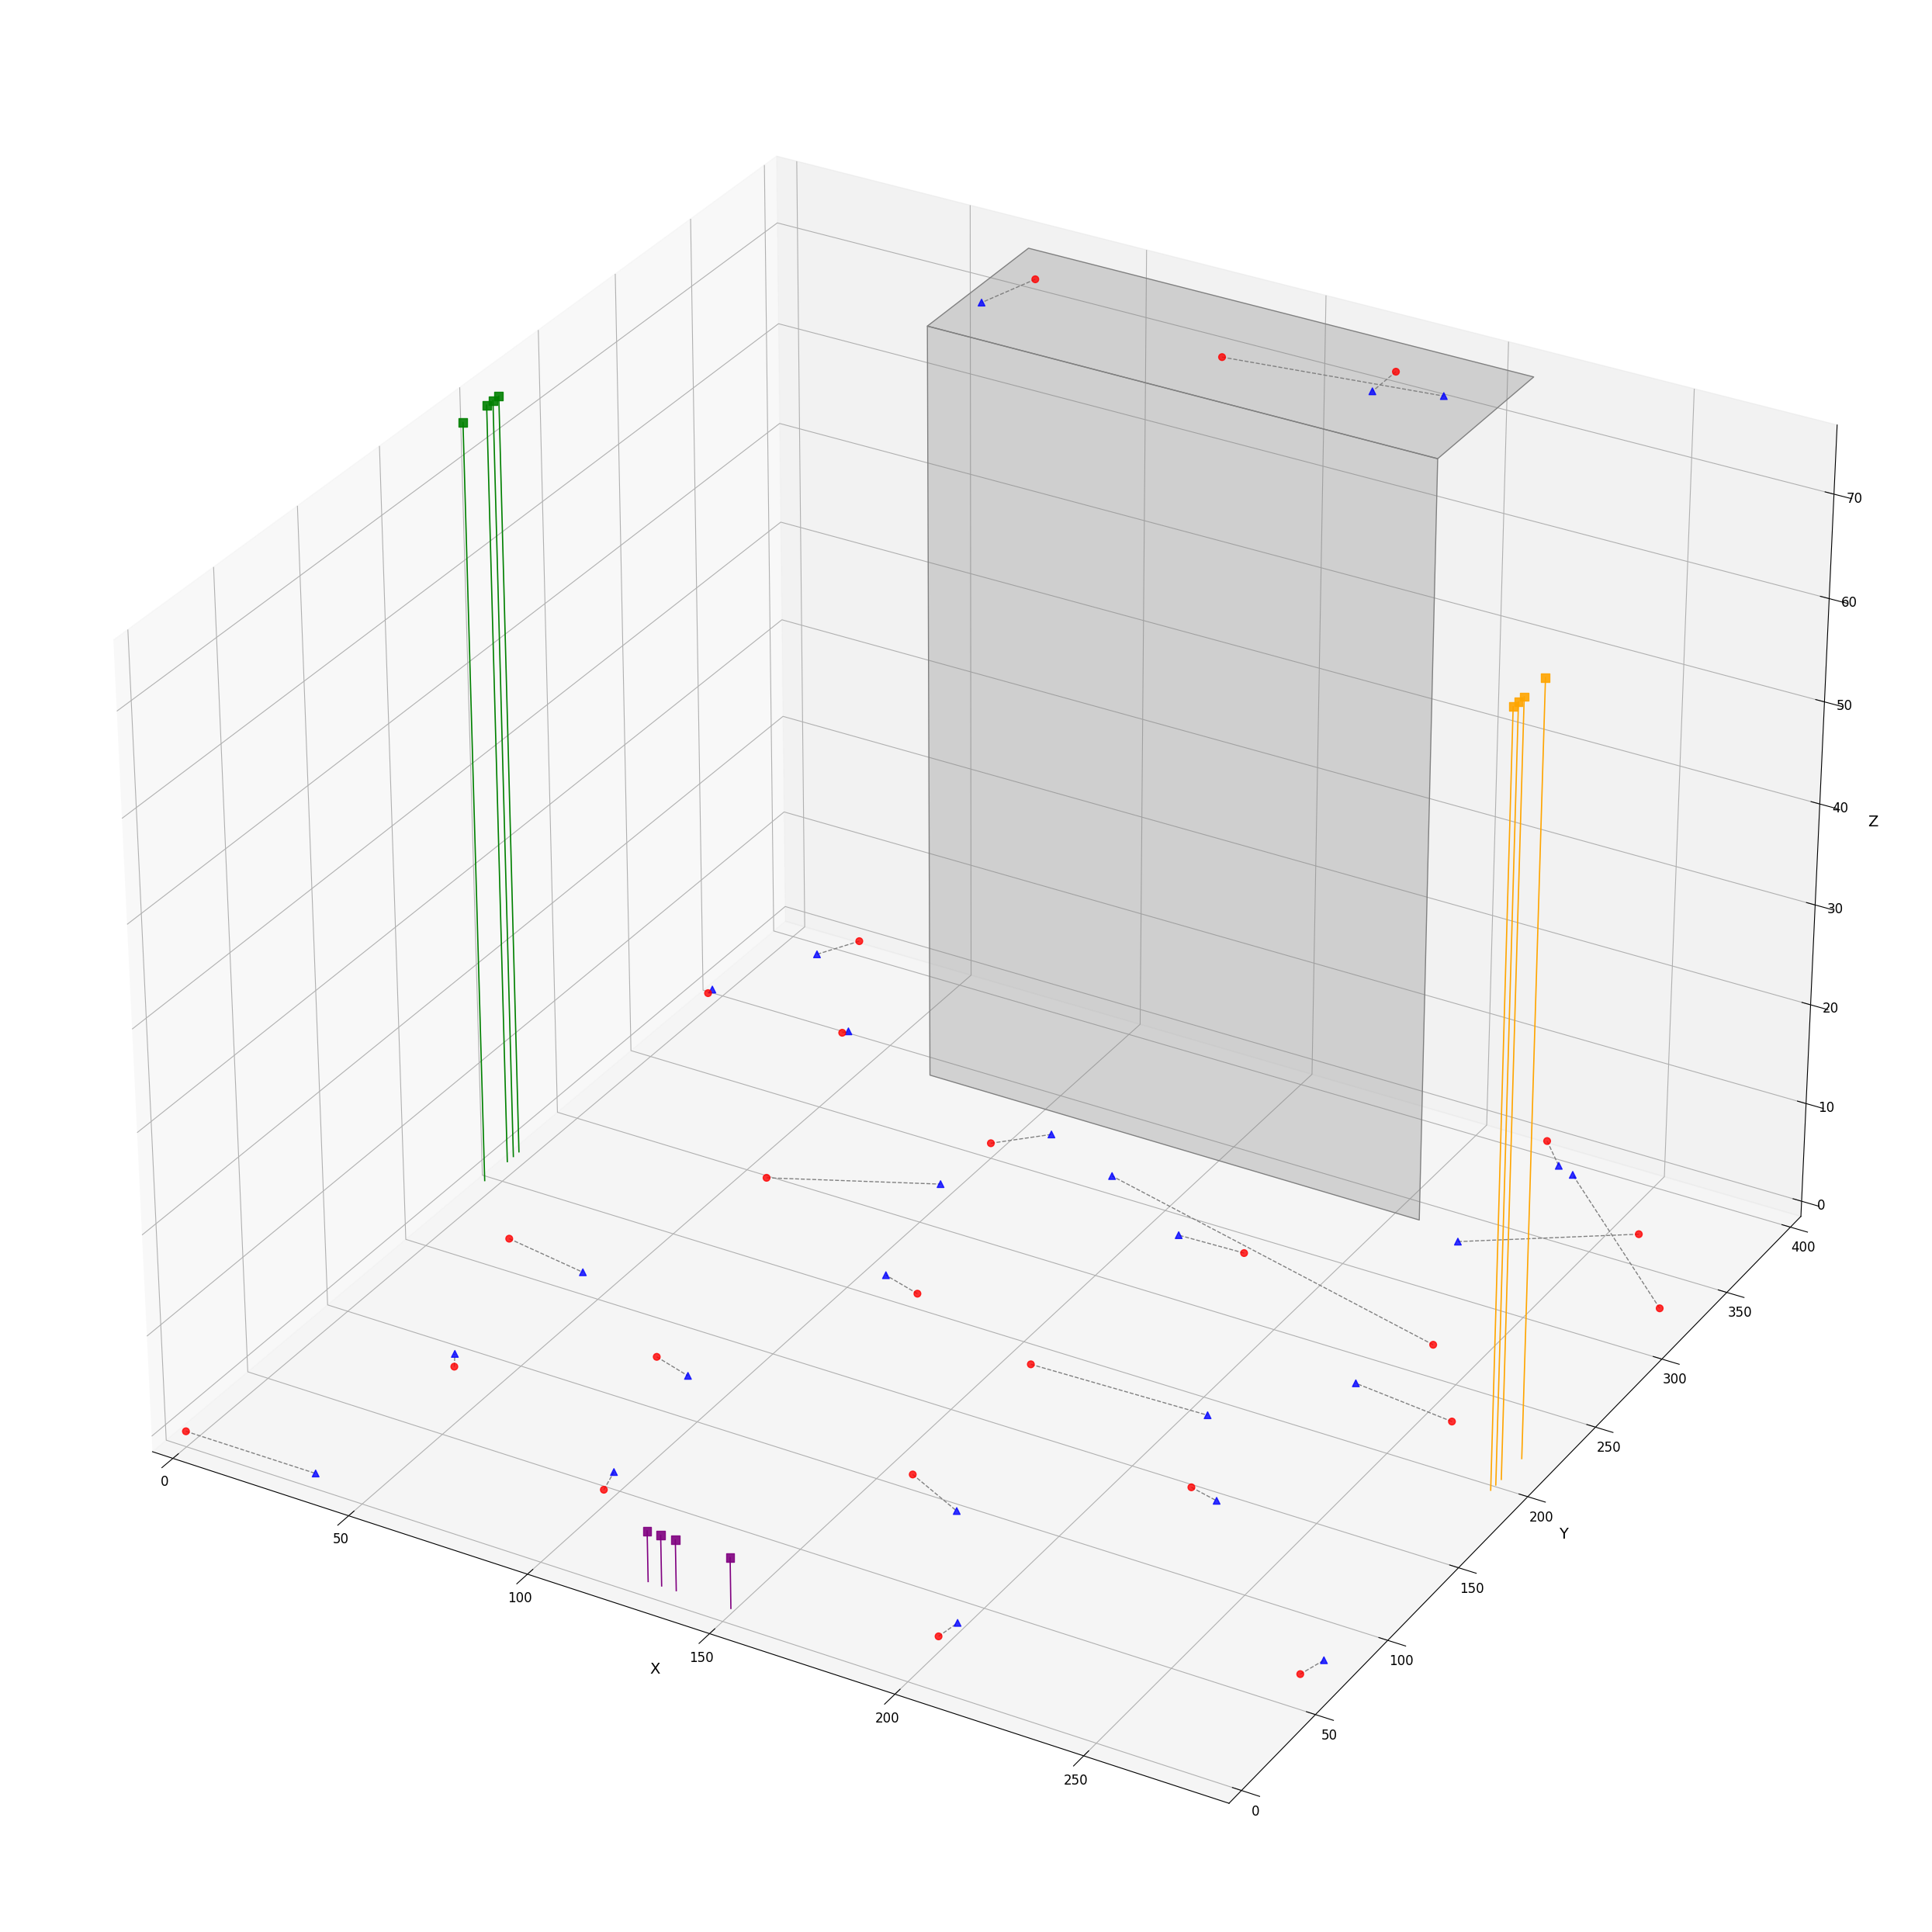

-----------
Actual: (0, 0, 0)
Predicted (37, 0, 0)
-----------
Actual: (200, 20, 0)
Predicted (201, 30, 0)
-----------
Actual: (100, 40, 0)
Predicted (98, 51, 0)
-----------
Actual: (280, 60, 0)
Predicted (282, 71, 0)
-----------
Actual: (40, 80, 0)
Predicted (37, 87, 0)
-----------
Actual: (160, 100, 0)
Predicted (177, 88, 0)
-----------
Actual: (80, 120, 0)
Predicted (91, 115, 0)
-----------
Actual: (220, 140, 0)
Predicted (228, 137, 0)
-----------
Actual: (20, 160, 0)
Predicted (44, 154, 0)
-----------
Actual: (160, 180, 0)
Predicted (208, 182, 0)
-----------
Actual: (120, 200, 0)
Predicted (109, 205, 0)
-----------
Actual: (260, 220, 0)
Predicted (232, 225, 0)
-----------
Actual: (60, 240, 0)
Predicted (99, 267, 0)
-----------
Actual: (240, 260, 0)
Predicted (134, 302, 0)
-----------
Actual: (180, 280, 0)
Predicted (162, 279, 0)
-----------
Actual: (100, 300, 0)
Predicted (111, 316, 0)
-----------
Actual: (280, 320, 0)
Predicted (233, 384, 0)
-----------
Actual: (0, 340, 0)
Predict

In [60]:
num_of_mics = 3
print('Number of Training Samples:', len(X_train))
print('Number of Test Samples:', len(y_test))
print('Method: Results for Classical approach using 3 Kinects')
print('GCC-PHAT interpolation:', 20)
print('Surface Classification Model:', surface_prediction_model)
print(f'Classification Accuracy: {accuracy_score(y_test, surface_prediction_model.predict(X_test))*100}%')
print('K1 samples used:', True, '\nK2 samples used:', False, '\nK3 samples used:', False)
# print('Number of Possible Epochs: 500, Early Stopping Patience: 100. Stopped after 121 epochs.')
# print('Model Summary:')
# raw_model.summary()
print('\nSSL Columns:', ssl_cols)
print('\n')
print('Results for model predictions:\n', mean_errors_dict)

plot_points(act_positions, predictied_positions, num_of_mics, k1=True, has_z=True, ranges_dict=ranges_dict)

for pos, pred in zip(act_positions, predictied_positions):
    print('-----------')
    print('Actual:', pos)
    print('Predicted', pred)

thresholds = [5, 10, 20, 30]
for threshold in thresholds:
    print('\n')
    counter = 0
    for pos, pred in zip(act_positions, predictied_positions):
        dif = math.sqrt((pos[0] - pred[0])**2 + (pos[1] - pred[1])**2 + (pos[2] - pred[2])**2)
        if dif <= threshold:
            counter += 1
    print(f'Accuracy with Threshold = {threshold}: {100 * (counter / len(predictied_positions))}%')

In [52]:
print(test_coors[24])

(20, 400, 0)


# **TDOA RMSE**

In [ ]:
def calculate_rmse(df1, df2):
    # Ensure both DataFrames have the same shape
    if df1.shape != df2.shape:
        raise ValueError("The two DataFrames must have the same shape.")
    # Calculate the element-wise difference
    error = df1 - df2
    # Calculate the squared error
    squared_error = error ** 2
    # Calculate the mean of the squared error
    mean_squared_error = squared_error.mean().mean()
    # Calculate the square root of the mean squared error
    rmse = np.sqrt(mean_squared_error)
    return rmse

In [ ]:
act_tdoa_df = create_actual_tdoas_df(coordinates, k1_info['positions'], k2_info['positions'], k3_info['positions'])
print(act_tdoa_df.shape)

sample (0, 0, 0) seen. sample (20, 0, 0) seen. sample (40, 0, 0) seen. sample (60, 0, 0) seen. sample (80, 0, 0) seen. sample (100, 0, 0) seen. sample (120, 0, 0) seen. sample (140, 0, 0) seen. sample (160, 0, 0) seen. sample (180, 0, 0) seen. sample (200, 0, 0) seen. sample (220, 0, 0) seen. sample (240, 0, 0) seen. sample (260, 0, 0) seen. sample (280, 0, 0) seen. sample (0, 20, 0) seen. sample (20, 20, 0) seen. sample (40, 20, 0) seen. sample (60, 20, 0) seen. sample (80, 20, 0) seen. sample (100, 20, 0) seen. sample (120, 20, 0) seen. sample (140, 20, 0) seen. sample (160, 20, 0) seen. sample (180, 20, 0) seen. sample (200, 20, 0) seen. sample (220, 20, 0) seen. sample (240, 20, 0) seen. sample (260, 20, 0) seen. sample (280, 20, 0) seen. sample (0, 40, 0) seen. sample (20, 40, 0) seen. sample (40, 40, 0) seen. sample (60, 40, 0) seen. sample (80, 40, 0) seen. sample (100, 40, 0) seen. sample (120, 40, 0) seen. sample (140, 40, 0) seen. sample (160, 40, 0) seen. sample (180, 40, 0)

In [ ]:
# Load measured TDOAs
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_tdoa_df_int20.pkl', 'rb') as file:
    tdoas_values_df = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(tdoas_values_df), '\nShape:', tdoas_values_df.shape, '\nOverview:', tdoas_values_df)

Loaded TDOAs dataframe.
Type: <class 'pandas.core.frame.DataFrame'> 
Shape: (315, 19) 
Overview:        tdoa01_k1    tdoa02_k1    tdoa03_k1    tdoa12_k1    tdoa13_k1  \
0    0.000481250  0.000537500  0.000656250  0.000056250  0.000209375   
1    0.000471875  0.000500000  0.000646875  0.000046875  0.000181250   
2    0.000481250  0.000459375  0.000653125  0.000062500  0.000150000   
3    0.000431250  0.000590625  0.000656250  0.000059375  0.000206250   
4    0.000421875  0.000571875  0.000656250  0.000068750  0.000212500   
..           ...          ...          ...          ...          ...   
310 -0.000018750 -0.000018750 -0.000028125 -0.000006250 -0.000012500   
311 -0.000046875 -0.000021875 -0.000031250 -0.000012500 -0.000025000   
312 -0.000015625 -0.000015625 -0.000018750 -0.000012500 -0.000018750   
313 -0.000062500 -0.000053125 -0.000071875 -0.000015625 -0.000028125   
314 -0.000059375 -0.000056250 -0.000071875 -0.000015625 -0.000034375   

       tdoa23_k1    tdoa01_k2    tdoa0

In [ ]:
print(act_tdoa_df)

        tdoa01_k1     tdoa02_k1     tdoa03_k1     tdoa12_k1     tdoa13_k1  \
0    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
1    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
2    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
3    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
4    0.0004344023  0.0005510204  0.0006588921  0.0001166181  0.0002244898   
..            ...           ...           ...           ...           ...   
310 -0.0000583248 -0.0000766069 -0.0000944988 -0.0000182821 -0.0000361740   
311 -0.0000801971 -0.0001043277 -0.0001276180 -0.0000241306 -0.0000474209   
312 -0.0001005128 -0.0001300160 -0.0001582434 -0.0000295032 -0.0000577306   
313 -0.0001201554 -0.0001548378 -0.0001878190 -0.0000346824 -0.0000676636   
314 -0.0001390317 -0.0001786777 -0.0002162099 -0.0000396460 -0.0000771782   

        tdoa23_k1     tdoa01_k2     tdoa02_k2     tdoa03_k2     tdoa12_k2  

In [ ]:
calculate_rmse(act_tdoa_df.drop('label', axis=1), tdoas_values_df.drop('label', axis=1))

6.192610051223122e-05

# **Inventory**

## **A new approach for positioning based on the cinjuction of lines**

In [ ]:
def find_intersection(ms, ys, three_kinects=False):
    if not three_kinects:
        m1, m2 = ms
        b1, b2 = ys
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        return x, y
    else:
        m1, m2, m3 = ms
        b1, b2, b3 = ys
        x1, y1 = find_intersection([m1, m2], [b1, b2])
        x2, y2 = find_intersection([m2, m3], [b2, b3])
        x3, y3 = find_intersection([m1, m3], [b1, b3])
        x = (x1 + x2 + x3) / 3
        y = (y1 + y2 + y3) / 3
        return x, y

In [ ]:
def get_line(predicted, k_pos):
    kx, ky = k_pos[:-1]
    pred_x, pred_y = predicted[:-1]
    m = (pred_y - ky) / (pred_x - kx + 1e-10)
    y_intercept = ky - m * kx
    return m, y_intercept

In [ ]:
def get_max_heatmap(heatmap, z_val):
    heatmap = heatmap / np.max(heatmap)
    z_max_idx, y_max_idx, x_max_idx = np.unravel_index(np.argmax(heatmap[z_val]), heatmap.shape)
    return (x_max_idx, y_max_idx, z_val)

In [ ]:
VALID = 1

def predict_pos_for_cor_k23(measured_tdoas, mic_pos1, mic_pos2, mic_pos3, comp_dict, comp_idx, z_val=-1, z_provided=True, x_minimum=0, x_maximum=283, y_minimum=0, y_maximum=401,
                        z_minimum=0, z_maximum=76, sigma=0.00001, sound_speed=34300.0, grid_resolution=1):
    # prepare heatmap
    heatmap_3d = env_array.copy()
    heatmap_3d_k2 = env_array.copy()
    heatmap_3d_k3 = env_array.copy()
    # determine z value
    z_values = [z_minimum, z_maximum - 1]
    if z_provided:
        z_values = [z_val]

    x_vals = np.arange(x_minimum, x_maximum, grid_resolution)
    y_vals = np.arange(y_minimum, y_maximum, grid_resolution)
    z_vals = np.arange(z_minimum, z_maximum, grid_resolution)

    # Evaluating the 3D grid cells
    for z in z_vals:
        if z in z_values:
            for y in y_vals:
                for x in x_vals:
                    # Initialize a variable to accumulate likelihood for the current grid point
                    likelihood_overal = 0
                    likelihood_k2 = 0
                    likelihood_k3 = 0
                    # Calculate distances from the grid point to each microphone
                    # distances_k1 = np.linalg.norm(mic_pos1 - np.array([x, y, z]), axis=1)
                    distances_k2 = np.linalg.norm(mic_pos2 - np.array([x, y, z]), axis=1)
                    distances_k3 = np.linalg.norm(mic_pos3 - np.array([x, y, z]), axis=1)
                    # Calculate expected TDOA based on these distances
                    expected_tdoas = {}
                    # expected_tdoas.update(get_expected_tdoas(distances_k1, 0))
                    expected_tdoas.update(get_expected_tdoas(distances_k2, 1))
                    expected_tdoas.update(get_expected_tdoas(distances_k3, 2))
                    # print(comp_dict[comp_idx])
                    # Compare the expected TDOAs with the measured TDOAs and update the likelihood
                    for key in comp_dict[comp_idx]:
                        likelihood_overal += np.exp(-((measured_tdoas[key] - expected_tdoas[key])**2) / (2 * sigma**2))
                    for key in comp_dict['a2']:
                        likelihood_k2 += np.exp(-((measured_tdoas[key] - expected_tdoas[key])**2) / (2 * sigma**2))
                    for key in comp_dict['a3']:
                        likelihood_k3 += np.exp(-((measured_tdoas[key] - expected_tdoas[key])**2) / (2 * sigma**2))
                    # Store the likelihood in the heatmap array if valid
                    temp = heatmap_3d[int((z - z_minimum) / grid_resolution),
                               int((y - y_minimum) / grid_resolution),
                               int((x - x_minimum) / grid_resolution)]
                    if temp == VALID:
                        heatmap_3d[int((z - z_minimum) / grid_resolution),
                                   int((y - y_minimum) / grid_resolution),
                                   int((x - x_minimum) / grid_resolution)] = likelihood_overal
                        heatmap_3d_k2[int((z - z_minimum) / grid_resolution),
                                   int((y - y_minimum) / grid_resolution),
                                   int((x - x_minimum) / grid_resolution)] = likelihood_k2
                        heatmap_3d_k3[int((z - z_minimum) / grid_resolution),
                                   int((y - y_minimum) / grid_resolution),
                                   int((x - x_minimum) / grid_resolution)] = likelihood_k3
    pred = get_max_heatmap(heatmap_3d, z_val)
    pred_k2 = get_max_heatmap(heatmap_3d_k2, z_val)
    pred_k3 = get_max_heatmap(heatmap_3d_k3, z_val)
    return pred, pred_k2, pred_k3

In [ ]:
def predict_with_interception(measured_tdoas, k2_pos, k3_pos, k2_middle, k3_middle, z_val, k1=False, k1_pos=None, k1_middle=None):
    # get predictions
    k2_pred = predict_pos_for_cor_for_one_kinect(measured_tdoas, k2_pos, 2, z_val)
    print(k2_pred)
    k3_pred = predict_pos_for_cor_for_one_kinect(measured_tdoas, k3_pos, 3, z_val)
    print('K3 predict', k3_pred)
    if not k2_pred[2] == k3_pred[2] == z_val:
        raise 'Unmatched Z values'
    if k1:
        k1_pred = predict_pos_for_cor_for_one_kinect(measured_tdoas, k1_pos, 1, z_val)
    # get lines
    k2_m, k2_b = get_line(k2_pred, k2_middle)
    print(k2_m, k2_b)
    k3_m, k3_b = get_line(k3_pred, k3_middle)
    print(k3_m, k3_b)
    if k1:
        k1_m, k1_b = get_line(k1_pred, k1_middle)
    # find the intersection of lines
    if k1:
        x, y = find_intersection([k1_m, k2_m, k3_m], [k1_b, k2_b, k3_b], three_kinects=True)
    else:
        x, y = find_intersection([k2_m, k3_m], [k2_b, k3_b])
    return x, y, z_val

In [ ]:
def gather_predictions(measured_tdoas, k2_pos, k3_pos, z_val):
    k2_pred = predict_pos_for_cor_for_one_kinect(measured_tdoas, k2_pos, 2, z_val)
    k3_pred = predict_pos_for_cor_for_one_kinect(measured_tdoas, k3_pos, 3, z_val)
    return k2_pred, k3_pred

# **MLP Model for refining the location estimation**

In the following section, an MLP is designed in order to be trained on the 290 samples predicted by kinect2 and kinect3 and their overal TDOA predictions in order to predicted the final prediction based on these values.

One thing would be to handle only x and y using this MLP. (If it works)

## **Load train Data**

In [ ]:
# Prepate data
# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/K2_predicitions_train.pkl', 'rb') as file:
    k2_train_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k2_train_predictions_list), '\nShape:', len(k2_train_predictions_list), '\nOverview:', k2_train_predictions_list)

# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/K3_predicitions_train.pkl', 'rb') as file:
    k3_train_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k3_train_predictions_list), '\nShape:', len(k3_train_predictions_list), '\nOverview:', k3_train_predictions_list)

# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/k2&3_predictions_train.pkl', 'rb') as file:
    k2_and_3_train_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k2_and_3_train_predictions_list), '\nShape:', len(k2_and_3_train_predictions_list), '\nOverview:', k2_and_3_train_predictions_list)

Loaded TDOAs dataframe.
Type: <class 'list'> 
Shape: 290 
Overview: [(276, 141, 0), (10, 46, 0), (282, 99, 0), (199, 0, 0), (6, 167, 0), (143, 197, 0), (72, 191, 0), (282, 43, 0), (282, 6, 0), (279, 13, 0), (282, 0, 0), (282, 0, 0), (282, 0, 0), (282, 0, 0), (0, 157, 0), (272, 142, 0), (282, 149, 0), (282, 139, 0), (273, 126, 0), (6, 228, 0), (0, 230, 0), (275, 105, 0), (279, 92, 0), (183, 0, 0), (282, 68, 0), (276, 37, 0), (279, 25, 0), (282, 0, 0), (169, 128, 0), (0, 333, 0), (51, 53, 0), (222, 136, 0), (186, 114, 0), (234, 128, 0), (96, 0, 0), (93, 0, 0), (135, 0, 0), (282, 98, 0), (274, 79, 0), (278, 60, 0), (282, 33, 0), (282, 0, 0), (209, 151, 0), (78, 101, 0), (1, 50, 0), (204, 144, 0), (161, 112, 0), (231, 139, 0), (236, 136, 0), (196, 108, 0), (77, 1, 0), (102, 0, 0), (188, 60, 0), (282, 100, 0), (275, 82, 0), (279, 61, 0), (0, 82, 0), (44, 98, 0), (63, 86, 0), (234, 149, 0), (172, 120, 0), (160, 98, 0), (106, 59, 0), (180, 99, 0), (178, 86, 0), (205, 94, 0), (275, 116, 0), (2

## **Load Test Data**

In [ ]:
# Prepate data
# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/K2_predicitions_test.pkl', 'rb') as file:
    k2_test_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k2_test_predictions_list), '\nShape:', len(k2_test_predictions_list), '\nOverview:', k2_test_predictions_list)

# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/K3_predicitions_test.pkl', 'rb') as file:
    k3_test_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k3_test_predictions_list), '\nShape:', len(k3_test_predictions_list), '\nOverview:', k3_test_predictions_list)

# Load tdoa lists
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/k2&3_predictions_test.pkl', 'rb') as file:
    k2_and_3_test_predictions_list = pickle.load(file)
    print('Loaded TDOAs dataframe.')
    print('Type:', type(k2_and_3_test_predictions_list), '\nShape:', len(k2_and_3_test_predictions_list), '\nOverview:', k2_and_3_test_predictions_list)

Loaded TDOAs dataframe.
Type: <class 'list'> 
Shape: 25 
Overview: [(172, 97, 0), (282, 85, 0), (281, 144, 0), (282, 27, 0), (1, 72, 0), (54, 2, 0), (0, 79, 0), (0, 0, 0), (3, 148, 0), (200, 181, 0), (178, 197, 0), (1, 277, 0), (202, 208, 0), (0, 388, 0), (216, 256, 0), (96, 324, 0), (220, 399, 0), (0, 340, 0), (1, 363, 0), (180, 400, 75), (209, 329, 0), (70, 358, 75), (200, 331, 75), (282, 217, 0), (279, 352, 0)]
Loaded TDOAs dataframe.
Type: <class 'list'> 
Shape: 25 
Overview: [(0, 0, 0), (33, 134, 0), (8, 108, 0), (0, 188, 0), (9, 98, 0), (112, 121, 0), (18, 144, 0), (62, 173, 0), (186, 95, 0), (183, 184, 0), (135, 206, 0), (270, 229, 0), (67, 254, 0), (0, 250, 0), (281, 328, 0), (219, 400, 0), (0, 258, 0), (3, 368, 0), (1, 324, 0), (97, 330, 75), (13, 245, 0), (96, 398, 75), (145, 330, 75), (0, 381, 0), (0, 258, 0)]
Loaded TDOAs dataframe.
Type: <class 'list'> 
Shape: 25 
Overview: [(35, 0, 0), (201, 30, 0), (98, 51, 0), (282, 71, 0), (37, 87, 0), (175, 89, 0), (91, 115, 0), (228,

## **Handle Data**

In [ ]:
# get x and y only
k2_train_predictions_list_2D = [(x, y) for (x, y, z) in k2_train_predictions_list]
k3_train_predictions_list_2D = [(x, y) for (x, y, z) in k3_train_predictions_list]
k2_and_3_train_predictions_list_2D = [(x, y) for (x, y, z) in k2_and_3_train_predictions_list]
k2_test_predictions_list_2D = [(x, y) for (x, y, z) in k2_test_predictions_list]
k3_test_predictions_list_2D = [(x, y) for (x, y, z) in k3_test_predictions_list]
k2_and_3_test_predictions_list_2D = [(x, y) for (x, y, z) in k2_and_3_test_predictions_list]

# create train and test
X_train = np.concatenate([k2_train_predictions_list_2D, k3_train_predictions_list_2D, k2_and_3_train_predictions_list_2D], axis=1)
X_test = np.concatenate([k2_test_predictions_list_2D, k3_test_predictions_list_2D, k2_and_3_test_predictions_list_2D], axis=1)
# X_train = np.array(k2_and_3_train_predictions_list_2D)
# X_test = np.array(k2_and_3_test_predictions_list_2D)
# create labels
train_labels = np.array([(x, y) for (x, y, z) in train_df['label'].to_list()])
test_labels = np.array([(x, y) for (x, y, z) in test_df['label'].to_list()])

# create validation data
X_train, X_val, train_labels, val_labels = train_test_split(X_train, train_labels, test_size=10, random_state=42)

print(X_train.shape, train_labels.shape)
print(X_val.shape, val_labels.shape)
print(X_test.shape, test_labels.shape)

(280, 6) (280, 2)
(10, 6) (10, 2)
(25, 6) (25, 2)


## **Get Model**

In [ ]:
# get the model
def get_model():
    # Define the model
    model = Sequential()
    model.add(Input((6,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='linear'))
    return model

In [ ]:
def lr_schedule(epoch, lr):
    if epoch > 100:
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Compile the model
mlp_model = get_model()
mlp_model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model
history = mlp_model.fit(X_train, train_labels,
                    validation_data=(X_val, val_labels),
                    epochs=300,
                    batch_size=8,
                    callbacks=[early_stopping])

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 12085.0020 - val_loss: 2588.3464
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3219.6443 - val_loss: 1976.5730
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2692.9319 - val_loss: 1714.1575
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2475.8594 - val_loss: 1684.2051
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1837.5847 - val_loss: 1310.5460
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2157.0681 - val_loss: 1384.0991
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1648.6072 - val_loss: 1269.2604
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2175.4998 - val_loss: 1287.3387
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1906.5654 - val_loss: 1096.5885
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1740.6228 - val_loss: 1010.5913
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1727.2361 - val_loss: 958.

In [ ]:
preds = mlp_model.predict(X_test)
print(*[(act, pred) for act, pred in zip(preds, test_labels)], sep='\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(array([18.756516 ,  3.1681213], dtype=float32), array([0, 0]))
(array([174.46619 ,  35.760582], dtype=float32), array([200,  20]))
(array([78.927055, 43.767086], dtype=float32), array([100,  40]))
(array([287.72403 ,  78.935715], dtype=float32), array([280,  60]))
(array([20.221045, 86.66494 ], dtype=float32), array([40, 80]))
(array([148.28464,  72.21605], dtype=float32), array([160, 100]))
(array([ 52.0946 , 108.56927], dtype=float32), array([ 80, 120]))
(array([173.83008 , 111.847374], dtype=float32), array([220, 140]))
(array([130.0158  , 118.372314], dtype=float32), array([ 20, 160]))
(array([173.06459, 178.0058 ], dtype=float32), array([160, 180]))
(array([123.580795, 198.2165  ], dtype=float32), array([120, 200]))
(array([245.30101, 198.64583], dtype=float32), array([260, 220]))
(array([106.54098, 252.10304], dtype=float32), array([ 60, 240]))
(array([163.9425, 299.1705], dtype=float32), array([240, 260]))
(array([189.05884, 261.66415], dty

In [ ]:
mean_errors_dict = calculate_mean_error(test_labels, preds)
print(mean_errors_dict)

{'mean_of_er_x for prediction': 27.35986461639404, 'mean_of_er_y for prediction': 21.287123260498046, 'mean_of_er_z for prediction': 0.0, 'mean_of_total_errors for prediction': 37.0326219850919}


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_labels, preds)
print(mse)

997.2569630374477


# **TDOA Estimation**

Let's run the tdoa estimation back once again.

In [ ]:
def get_tdoa_ref_model(input_shape):